In [1]:
# 아래의 튜닝 기반으로 진행하고자 합니다.
# RandomSearch, HalvingGridSearch등 속도가 더 빠른 것들도 있지만
# 우선 Grid로만 진행하는 것이 현재로서는 조금더 직관적이긴 합니다 (다만, 약간의 노가다성,,,이 추가됩니다.)

In [2]:
#   grid = GridSearchCV(clf, param_grid = params[x], cv = 5, n_jobs = -1)
#     grid.fit
    
    
#     print(clf.__class__.__name__, "모델 튜닝 완료")
#     print(clf.__class__.__name__, "튜닝 후 4Pic 테스트 완료")
#     x += 1

In [2]:
import time
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier #pip install xgboost
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# device_lib.list_local_devices()
# tf.config.list_physical_devices('GPU')

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV
import random

import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings(): warnings.filterwarnings('ignore', category=ConvergenceWarning)

b:\OWNER\envs\tensorflow\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# MNIST 데이터 셋 준비
# Original / 교수님 제공 Handmade / 팀원 Handmade / Combined (OG + HM)

# Original MNIST 데이터
mnist_og = fetch_openml('mnist_784', version=1)
mnist_og.target = mnist_og.target.astype(np.uint8)
X_og = mnist_og["data"].to_numpy()
y_og = mnist_og["target"].to_numpy()
X_og = X_og.reshape(len(X_og), 784)

# 교수님 제공 HM 데이터
mnist_hm = np.load('H_MNIST_train.npz')
X_hm = mnist_hm['img']
y_hm = mnist_hm['label']
X_hm = X_hm.reshape(len(X_hm), 784)

# 팀원 HM 데이터
mnist_team = [np.load('mnist_hbk.npz'), np.load('mnist_psh.npz'), np.load('mnist_shs.npz')]
X_team = np.concatenate((mnist_team[0]['img'], mnist_team[1]['img'], mnist_team[2]['img']), axis=0)
y_team = np.concatenate((mnist_team[0]['label'], mnist_team[1]['label'], mnist_team[2]['label']), axis=0)
X_team = X_team.reshape(len(X_team), 784)

# xla원의 HM 데이터 중 4장은 테스트 데이터로 간주합니다.
mnist_4pic = [np.load('mnist_4pic2.npz')]
X_4pic = mnist_4pic[0]['img']
y_4pic = mnist_4pic[0]['label']
X_4pic = X_4pic.reshape(len(X_4pic), 784)


# Combined 데이터 셋 (OG + HM)
X_cb = np.concatenate((X_og, X_hm), axis=0)
y_cb = np.concatenate((y_og, y_hm), axis=0)
X_cb = X_cb.reshape(len(X_cb), 784)

# 데이터셋 Masking 및 Reshape 진행
X_list = [X_og, X_hm, X_team, X_4pic, X_cb]
for X in X_list:
    for i in range(len(X)):
        np.putmask(X[i], X[i] > 0, 255.0)
                   
# for i in range(len(X_og)):
#     np.putmask(X_og[i], X_og[i] > 0, 255.0)

# for i in range(len(X_hm)):
#     np.putmask(X_hm[i], X_hm[i] > 0, 255.0)

# for i in range(len(X_team)):
#     np.putmask(X_team[i], X_team[i] > 0, 255.0)

# for i in range(len(X_4pic)):
#     np.putmask(X_4pic[i], X_4pic[i] > 0, 255.0)

# for i in range(len(X_cb)):
#     np.putmask(X_cb[i], X_cb[i] > 0, 255.0)

# # 데이터셋 Reshape 진행
# X_og = X_og.reshape(len(X_og), 784)
# X_hm = X_hm.reshape(len(X_hm), 784)
# X_team = X_hm.reshape(len(X_team), 784)
# X_4pic = X_4pic.reshape(len(X_4pic), 784)
# X_cb = X_cb.reshape(len(X_cb), 784)

# Train Test 분리
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, y_og, random_state=42)
X_train_hm, X_test_hm, y_train_hm, y_test_hm = train_test_split(X_hm, y_hm, random_state=42)
X_train_team, X_test_team, y_train_team, y_test_team = train_test_split(X_team, y_team, random_state=42)
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, random_state=42)

In [4]:
from sklearn.ensemble import VotingClassifier
# 모델 및 파라미터 생성
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# 모델 생성 (ABC순)
dt_og = DecisionTreeClassifier()
et_og = ExtraTreesClassifier()
knn_og = KNeighborsClassifier()
log_og = LogisticRegression()
mlp_og = MLPClassifier()
rf_og = RandomForestClassifier()
svm_og = SVC()
xgb_og = XGBClassifier()

dt_hm = DecisionTreeClassifier()
et_hm = ExtraTreesClassifier()
knn_hm = KNeighborsClassifier()
log_hm = LogisticRegression()
mlp_hm = MLPClassifier()
rf_hm = RandomForestClassifier()
svm_hm = SVC()
xgb_hm = XGBClassifier()

dt_cb = DecisionTreeClassifier()
et_cb = ExtraTreesClassifier()
knn_cb = KNeighborsClassifier()
log_cb = LogisticRegression()
mlp_cb = MLPClassifier()
rf_cb = RandomForestClassifier()
svm_cb = SVC()
xgb_cb = XGBClassifier()

classifiers_og = [et_og, log_og, mlp_og, rf_og]
classifiers_hm = [et_hm, log_hm, mlp_hm, rf_hm]
classifiers_cb = [et_cb, log_cb, mlp_cb, rf_cb]

# 파라미터 후보 생성 (ABC 순)
params_et = {'criterion': ['gini', 'entropy', 'log_loss'], 
             'max_depth': list(range(5, 35, 5)), 
             'max_features': ['sqrt', 'log2', None], 
             'min_samples_leaf': list(range(5, 35, 5)), 
             'min_samples_split': list(range(5, 35, 5)), 
             'n_estimators': list(range(100, 1100, 100)), 
             'n_jobs': [6], 
             'random_state': [42]}

params_log = {'C': [0.5, 1.0, 1.5], 
              'max_iter': list(range(500, 3100, 500)), 
              'multi_class': ['auto', 'ovr'], 
              'n_jobs': [-1], 
              'penalty': ['l2'], 
              'random_state': [42], 
              'solver': ['lbfgs', 'sag'], 
              'tol': [0.0001]}

params_mlp = {'hidden_layer_sizes' : list(range(10, 155, 5)),
              'max_iter' : list(range(500, 3100, 500)),
              'alpha' : [1e-4, 1e-3, 1e-2],
              'solver' : ['sgd', 'adam'],
              'activation' : ['identity', 'logistic', 'tanh', 'relu'],
              'random_state' : [42],
              'learning_rate_init' : [0.1, 0.01, 0.001]}

params_rf = {'criterion': ['gini'], 
             'max_depth': [5, 10, 15 ,20], 
             'max_features': ['sqrt', 'log2', None], 
             'max_samples': [0.2, 0.4, 0.7, 0.8, 0.9, 1.0], 
             'min_samples_leaf': list(range(5, 35, 5)), 
             'min_samples_split': list(range(5, 35, 5)), 
             'n_estimators': list(range(100, 1100, 100)), 
             'n_jobs': [6], 
             'random_state': [42]}

params = [params_et, params_log, params_mlp, params_rf]

In [6]:
# 출력해야하는 지표
# 예측: prediction
# 시간: learning time, inference time
# 점수: score, accuracy
# 학습 커브: Epoch 및 learning curve
np.set_printoptions(threshold=5)

LearningTime_og_og = {}
InferenceTime_og_og = {}
TrainScore_og_og = {}
TestScore_og_og = {}
AccuracyScore_og_og = {}
Prediction_og_og = {}
LearningCurve_og_og = []

InferenceTime_hm_og = {}
TrainScore_hm_og = {}
TestScore_hm_og = {}
AccuracyScore_hm_og = {}
Prediction_hm_og = {}
LearningCurve_hm_og = []

InferenceTime_4pic_og = {}
TestScore_4pic_og = {}
AccuracyScore_4pic_og = {}
Prediction_4pic_og = {}
LearningCurve_4pic_og = []

In [7]:
# Original 데이터셋에 대한 학습 진행
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

print("Original '데이터셋 학습' / '4Pic 테스트' 진행\n")
print("위 셀의 코드 실행 확인용 소요시간 출력")
clf = []
for clf in classifiers_og:    
    clftime = time.time()
    start_learn = time.time()
    clf.fit(X_train_og, y_train_og)
    end_learn = time.time()
    start_inference = time.time()
    y_pred_og_og = clf.predict(X_test_og)
    end_inference = time.time()
    
    LearningTime_og_og[clf.__class__.__name__] = (end_learn - start_learn)
    InferenceTime_og_og[clf.__class__.__name__] = (end_inference - start_inference)
    TrainScore_og_og[clf.__class__.__name__] = (clf.score(X_train_og, y_train_og))
    TestScore_og_og[clf.__class__.__name__] = (clf.score(X_test_og, y_test_og))
    AccuracyScore_og_og[clf.__class__.__name__] = (accuracy_score(y_test_og, y_pred_og_og))
    Prediction_og_og[clf.__class__.__name__] = (y_pred_og_og)
                            
    start_inference = time.time()
    y_pred_hm_og = clf.predict(X_test_hm)
    end_inference = time.time()
    
    InferenceTime_hm_og[clf.__class__.__name__] = (end_inference - start_inference)
    TrainScore_hm_og[clf.__class__.__name__] = (clf.score(X_train_hm, y_train_hm))
    TestScore_hm_og[clf.__class__.__name__] = (clf.score(X_test_hm, y_test_hm))
    AccuracyScore_hm_og[clf.__class__.__name__] = (accuracy_score(y_test_hm, y_pred_hm_og))
    Prediction_hm_og[clf.__class__.__name__] = (y_pred_hm_og)

                            
    start_inference = time.time()
    y_pred_4pic_og = clf.predict(X_4pic)
    end_inference = time.time()
    
    InferenceTime_4pic_og[clf.__class__.__name__] = (end_inference - start_inference)
    TestScore_4pic_og[clf.__class__.__name__] = (clf.score(X_4pic, y_4pic))
    AccuracyScore_4pic_og[clf.__class__.__name__] = (accuracy_score(y_4pic, y_pred_4pic_og))
    Prediction_4pic_og[clf.__class__.__name__] = (y_pred_4pic_og)
    
    print(clf.__class__.__name__, "완료", time.time()-clftime, "초")

Original '데이터셋 학습' / '4Pic 테스트' 진행

위 셀의 코드 실행 확인용 소요시간 출력
ExtraTreesClassifier 완료 36.70849084854126 초
LogisticRegression 완료 10.761011123657227 초
MLPClassifier 완료 94.97292256355286 초
RandomForestClassifier 완료 23.72800350189209 초


In [8]:
best_param_og_og = {}

Tuned_InferenceTime_og_og = {}
Tuned_TrainScore_og_og = {}
Tuned_TestScore_og_og = {}
Tuned_AccuracyScore_og_og = {}
Tuned_Prediction_og_og = {}
Tuned_LearningCurve_og_og = []

Tuned_InferenceTime_hm_og = {}
Tuned_TrainScore_hm_og = {}
Tuned_TestScore_hm_og = {}
Tuned_AccuracyScore_hm_og = {}
Tuned_Prediction_hm_og = {}
Tuned_LearningCurve_hm_og = []

Tuned_InferenceTime_4pic_og = {}
Tuned_TestScore_4pic_og = {}
Tuned_AccuracyScore_4pic_og = {}
Tuned_Prediction_4pic_og = {}
Tuned_LearningCurve_4pic_og = []

In [9]:
# Original 데이터셋에 대한 파라미터 튜닝 진행 + learning curve에서 파라미터 별 변화 그래프 확인
with warnings.catch_warnings(): warnings.filterwarnings('ignore', category=ConvergenceWarning)
print("Original '파라미터 튜닝' / '테스트' 진행\n")
print("위 셀의 코드 실행 확인용 소요시간 출력")
x = 0
HRS_CV_og = []
for clf in classifiers_og:
    clftime = time.time()
    HRS_CV_og = HalvingRandomSearchCV(clf, param_distributions = params[x], cv = 3, n_jobs = 4)
    HRS_CV_og.fit(X_train_og, y_train_og)
    best_param_og_og[clf.__class__.__name__] = HRS_CV_og.best_params_
    
    start_inference = time.time()
    y_pred_og_og = HRS_CV_og.best_estimator_.predict(X_test_og)
    end_inference = time.time()
    
    Tuned_InferenceTime_og_og[clf.__class__.__name__] = end_inference - start_inference
    Tuned_TrainScore_og_og[clf.__class__.__name__] = HRS_CV_og.best_estimator_.score(X_train_og, y_train_og)
    Tuned_TestScore_og_og[clf.__class__.__name__] = HRS_CV_og.best_estimator_.score(X_test_og, y_test_og)
    Tuned_AccuracyScore_og_og[clf.__class__.__name__] = accuracy_score(y_test_og, y_pred_og_og)
    Tuned_Prediction_og_og[clf.__class__.__name__] = y_pred_og_og
    
    start_inference = time.time()
    y_pred_hm_og = HRS_CV_og.best_estimator_.predict(X_test_hm)
    end_inference = time.time()
    
    Tuned_InferenceTime_hm_og[clf.__class__.__name__] = end_inference - start_inference
    Tuned_TrainScore_hm_og[clf.__class__.__name__] = HRS_CV_og.best_estimator_.score(X_train_hm, y_train_hm)
    Tuned_TestScore_hm_og[clf.__class__.__name__] = HRS_CV_og.best_estimator_.score(X_test_hm, y_test_hm)
    Tuned_AccuracyScore_hm_og[clf.__class__.__name__] = accuracy_score(y_test_hm, y_pred_hm_og)
    Tuned_Prediction_hm_og[clf.__class__.__name__] = y_pred_hm_og
    
    start_inference = time.time()
    y_4pic_og = HRS_CV_og.best_estimator_.predict(X_4pic)
    end_inference = time.time()
    
    Tuned_InferenceTime_4pic_og[clf.__class__.__name__] = end_inference - start_inference
    Tuned_TestScore_4pic_og[clf.__class__.__name__] = HRS_CV_og.best_estimator_.score(X_4pic, y_4pic)
    Tuned_AccuracyScore_4pic_og[clf.__class__.__name__] = accuracy_score(y_4pic, y_4pic_og)
    Tuned_Prediction_4pic_og[clf.__class__.__name__] = y_4pic_og
    
    print(clf.__class__.__name__, "완료", time.time()-clftime, "초")
    x+=1

Original '파라미터 튜닝' / '테스트' 진행

위 셀의 코드 실행 확인용 소요시간 출력
ExtraTreesClassifier 완료 1531.0163147449493 초
LogisticRegression 완료 2594.095472097397 초
MLPClassifier 완료 1365.2042763233185 초
RandomForestClassifier 완료 974.713000535965 초


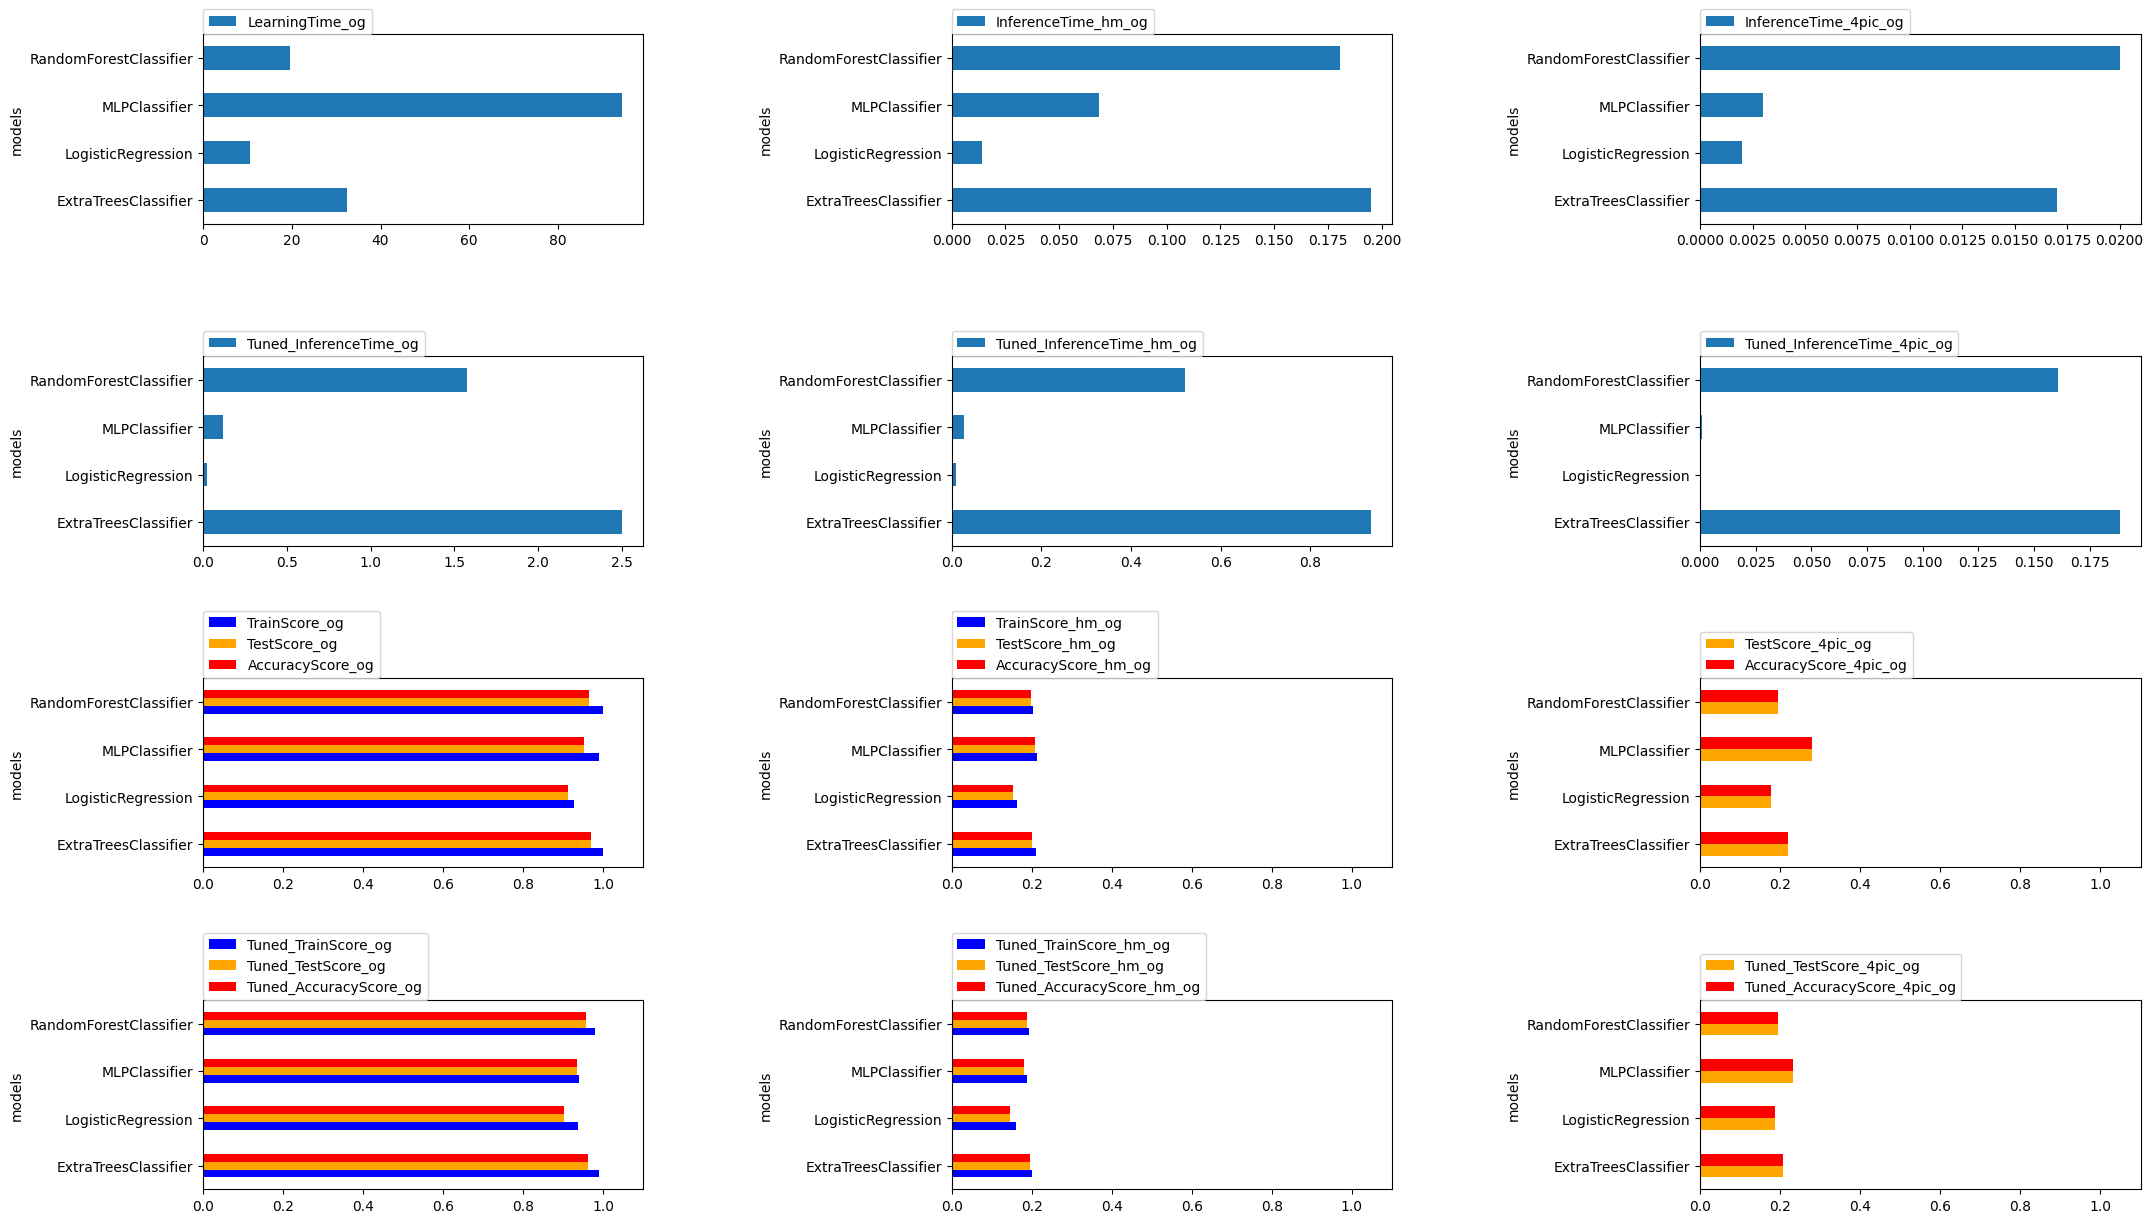

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
og_og = {'models': list(InferenceTime_og_og.keys()), 
      'LearningTime_og':list(LearningTime_og_og.values()),
      'InferenceTime_og':list(InferenceTime_og_og.values()),
      'TrainScore_og':list(TrainScore_og_og.values()),
      'TestScore_og':list(TestScore_og_og.values()),
      'AccuracyScore_og':list(AccuracyScore_og_og.values()),}

hm_og = {'models': list(InferenceTime_hm_og.keys()), 
         'InferenceTime_hm_og':list(InferenceTime_hm_og.values()),
         'TrainScore_hm_og':list(TrainScore_hm_og.values()),
         'TestScore_hm_og':list(TestScore_hm_og.values()),
         'AccuracyScore_hm_og':list(AccuracyScore_hm_og.values())}

pic_og = {'models': list(InferenceTime_4pic_og.keys()), 
          'InferenceTime_4pic_og':list(InferenceTime_4pic_og.values()),
          'TestScore_4pic_og':list(TestScore_4pic_og.values()),
          'AccuracyScore_4pic_og':list(AccuracyScore_4pic_og.values())}

Tuned_og_og = {'models': list(Tuned_InferenceTime_og_og.keys()), 
            'Tuned_InferenceTime_og':list(Tuned_InferenceTime_og_og.values()),
            'Tuned_TrainScore_og':list(Tuned_TrainScore_og_og.values()),
            'Tuned_TestScore_og':list(Tuned_TestScore_og_og.values()),
            'Tuned_AccuracyScore_og':list(Tuned_AccuracyScore_og_og.values()),}

Tuned_hm_og = {'models': list(Tuned_InferenceTime_hm_og.keys()), 
               'Tuned_InferenceTime_hm_og':list(Tuned_InferenceTime_hm_og.values()),
               'Tuned_TrainScore_hm_og':list(Tuned_TrainScore_hm_og.values()),
               'Tuned_TestScore_hm_og':list(Tuned_TestScore_hm_og.values()),
               'Tuned_AccuracyScore_hm_og':list(Tuned_AccuracyScore_hm_og.values())}

Tuned_pic_og = {'models': list(Tuned_InferenceTime_4pic_og.keys()), 
                'Tuned_InferenceTime_4pic_og':list(Tuned_InferenceTime_4pic_og.values()),
                'Tuned_TestScore_4pic_og':list(Tuned_TestScore_4pic_og.values()),
                'Tuned_AccuracyScore_4pic_og':list(Tuned_AccuracyScore_4pic_og.values())}

og_og = pd.DataFrame(og_og)
hm_og = pd.DataFrame(hm_og)
pic_og = pd.DataFrame(pic_og)

Tuned_og_og = pd.DataFrame(Tuned_og_og)
Tuned_hm_og = pd.DataFrame(Tuned_hm_og)
Tuned_pic_og = pd.DataFrame(Tuned_pic_og)

fig, ax = plt.subplots(4, 3, figsize = (25, 15))

og_og.plot(kind='barh', x='models', y=list(og_og.keys())[1], ax=ax[0,0])
hm_og.plot(kind='barh', x='models', y=list(hm_og.keys())[1], ax=ax[0,1])
pic_og.plot(kind='barh', x='models', y=list(pic_og.keys())[1], ax=ax[0,2])

Tuned_og_og.plot(kind='barh', x='models', y=list(Tuned_og_og.keys())[1], ax=ax[1,0])
Tuned_hm_og.plot(kind='barh', x='models', y=list(Tuned_hm_og.keys())[1], ax=ax[1,1])
Tuned_pic_og.plot(kind='barh', x='models', y=list(Tuned_pic_og.keys())[1], ax=ax[1,2])

og_og.plot(kind='barh', x='models', y=list(og_og.keys())[3:], ax=ax[2,0], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
hm_og.plot(kind='barh', x='models', y=list(hm_og.keys())[2:], ax=ax[2,1], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
pic_og.plot(kind='barh', x='models', y=list(pic_og.keys())[2:], ax=ax[2,2], xlim = (0,1.1), color = ['orange', 'red'])

Tuned_og_og.plot(kind='barh', x='models', y=list(Tuned_og_og.keys())[2:], ax=ax[3,0], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
Tuned_hm_og.plot(kind='barh', x='models', y=list(Tuned_hm_og.keys())[2:], ax=ax[3,1], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
Tuned_pic_og.plot(kind='barh', x='models', y=list(Tuned_pic_og.keys())[2:], ax=ax[3,2], xlim = (0,1.1), color = ['orange', 'red'])

ax[0,0].legend(loc=(0,1))
ax[0,1].legend(loc=(0,1))
ax[0,2].legend(loc=(0,1))
ax[1,0].legend(loc=(0,1))
ax[1,1].legend(loc=(0,1))
ax[1,2].legend(loc=(0,1))
ax[2,0].legend(loc=(0,1))
ax[2,1].legend(loc=(0,1))
ax[2,2].legend(loc=(0,1))
ax[3,0].legend(loc=(0,1))
ax[3,1].legend(loc=(0,1))
ax[3,2].legend(loc=(0,1))
plt.subplots_adjust(wspace=0.7, hspace=0.7)

In [11]:
og_og

,models,LearningTime_og,InferenceTime_og,TrainScore_og,TestScore_og,AccuracyScore_og
0,ExtraTreesClassifier,32.340859,0.687017,1.000000,0.970000,0.970000
1,LogisticRegression,10.526009,0.025001,0.927619,0.910971,0.910971
2,MLPClassifier,94.500357,0.060510,0.989676,0.951143,0.951143
3,RandomForestClassifier,19.517731,0.668028,1.000000,0.965429,0.965429


In [12]:
Tuned_og_og

,models,Tuned_InferenceTime_og,Tuned_TrainScore_og,Tuned_TestScore_og,Tuned_AccuracyScore_og
0,ExtraTreesClassifier,2.502938,0.990210,0.962343,0.962343
1,LogisticRegression,0.022999,0.936210,0.902857,0.902857
2,MLPClassifier,0.121999,0.938152,0.933371,0.933371
3,RandomForestClassifier,1.574999,0.980038,0.957029,0.957029


In [13]:
hm_og

,models,InferenceTime_hm_og,TrainScore_hm_og,TestScore_hm_og,AccuracyScore_hm_og
0,ExtraTreesClassifier,0.195022,0.209880,0.201796,0.201796
1,LogisticRegression,0.014001,0.164022,0.154192,0.154192
2,MLPClassifier,0.068516,0.212226,0.208683,0.208683
3,RandomForestClassifier,0.180531,0.204291,0.197455,0.197455


In [14]:
Tuned_hm_og

,models,Tuned_InferenceTime_hm_og,Tuned_TrainScore_hm_og,Tuned_TestScore_hm_og,Tuned_AccuracyScore_hm_og
0,ExtraTreesClassifier,0.935035,0.200549,0.195659,0.195659
1,LogisticRegression,0.009003,0.161128,0.146856,0.146856
2,MLPClassifier,0.028000,0.189471,0.180090,0.180090
3,RandomForestClassifier,0.520000,0.193413,0.187575,0.187575


In [15]:
pic_og

,models,InferenceTime_4pic_og,TestScore_4pic_og,AccuracyScore_4pic_og
0,ExtraTreesClassifier,0.017000,0.2200,0.2200
1,LogisticRegression,0.002000,0.1775,0.1775
2,MLPClassifier,0.003001,0.2800,0.2800
3,RandomForestClassifier,0.020002,0.1950,0.1950


In [16]:
Tuned_pic_og

,models,Tuned_InferenceTime_4pic_og,Tuned_TestScore_4pic_og,Tuned_AccuracyScore_4pic_og
0,ExtraTreesClassifier,0.188510,0.2075,0.2075
1,LogisticRegression,0.000000,0.1875,0.1875
2,MLPClassifier,0.001001,0.2325,0.2325
3,RandomForestClassifier,0.161001,0.1950,0.1950


In [17]:
# 출력해야하는 지표
# 예측: prediction
# 시간: learning time, inference time
# 점수: score, accuracy
# 학습 커브: Epoch 및 learning curve
np.set_printoptions(threshold=5)

LearningTime_og_hm = {}
InferenceTime_og_hm = {}
TrainScore_og_hm = {}
TestScore_og_hm = {}
AccuracyScore_og_hm = {}
Prediction_og_hm = {}
LearningCurve_og_hm = []

InferenceTime_hm_hm = {}
TrainScore_hm_hm = {}
TestScore_hm_hm = {}
AccuracyScore_hm_hm = {}
Prediction_hm_hm = {}
LearningCurve_hm_hm = []

InferenceTime_4pic_hm = {}
TestScore_4pic_hm = {}
AccuracyScore_4pic_hm = {}
Prediction_4pic_hm = {}
LearningCurve_4pic_hm = []

In [18]:
# Homemade 데이터셋에 대한 학습 진행
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

print("Homemade '데이터셋 학습' / '4Pic 테스트' 진행\n")
print("위 셀의 코드 실행 확인용 소요시간 출력")
clf_hm = []
for clf_hm in classifiers_hm:
    clf_hm_time = time.time()
    start_learn = time.time()
    clf_hm.fit(X_train_hm, y_train_hm)
    end_learn = time.time()

    start_inference = time.time()
    y_pred_og_hm = clf_hm.predict(X_test_og)
    end_inference = time.time()
    LearningTime_og_hm[clf_hm.__class__.__name__] = (end_learn - start_learn)
    InferenceTime_og_hm[clf_hm.__class__.__name__] = (end_inference - start_inference)
    TrainScore_og_hm[clf_hm.__class__.__name__] = (clf_hm.score(X_train_og, y_train_og))
    TestScore_og_hm[clf_hm.__class__.__name__] = (clf_hm.score(X_test_og, y_test_og))
    AccuracyScore_og_hm[clf_hm.__class__.__name__] = (accuracy_score(y_test_og, y_pred_og_hm))
    Prediction_og_hm[clf_hm.__class__.__name__] = (y_pred_og_hm)
                            
    start_inference = time.time()
    y_pred_hm_hm = clf_hm.predict(X_test_hm)
    end_inference = time.time()
    
    InferenceTime_hm_hm[clf_hm.__class__.__name__] = (end_inference - start_inference)
    TrainScore_hm_hm[clf_hm.__class__.__name__] = (clf_hm.score(X_train_hm, y_train_hm))
    TestScore_hm_hm[clf_hm.__class__.__name__] = (clf_hm.score(X_test_hm, y_test_hm))
    AccuracyScore_hm_hm[clf_hm.__class__.__name__] = (accuracy_score(y_test_hm, y_pred_hm_hm))
    Prediction_hm_hm[clf_hm.__class__.__name__] = (y_pred_hm_hm)

                            
    start_inference = time.time()
    y_pred_4pic_hm = clf_hm.predict(X_4pic)
    end_inference = time.time()
    
    InferenceTime_4pic_hm[clf_hm.__class__.__name__] = (end_inference - start_inference)
    TestScore_4pic_hm[clf_hm.__class__.__name__] = (clf_hm.score(X_4pic, y_4pic))
    AccuracyScore_4pic_hm[clf_hm.__class__.__name__] = (accuracy_score(y_4pic, y_pred_4pic_hm))
    Prediction_4pic_hm[clf_hm.__class__.__name__] = (y_pred_4pic_hm)
    
    print(clf_hm.__class__.__name__, "완료", time.time()-clf_hm_time, "초")
    

Homemade '데이터셋 학습' / '4Pic 테스트' 진행

위 셀의 코드 실행 확인용 소요시간 출력
ExtraTreesClassifier 완료 17.059019327163696 초
LogisticRegression 완료 2.277980089187622 초
MLPClassifier 완료 41.33899807929993 초
RandomForestClassifier 완료 11.84000039100647 초


In [19]:
best_param_hm = {}

Tuned_InferenceTime_og_hm = {}
Tuned_TrainScore_og_hm = {}
Tuned_TestScore_og_hm = {}
Tuned_AccuracyScore_og_hm = {}
Tuned_Prediction_og_hm = {}
Tuned_LearningCurve_og_hm = []

Tuned_InferenceTime_hm_hm = {}
Tuned_TrainScore_hm_hm = {}
Tuned_TestScore_hm_hm = {}
Tuned_AccuracyScore_hm_hm = {}
Tuned_Prediction_hm_hm = {}
Tuned_LearningCurve_hm_hm = []

Tuned_InferenceTime_4pic_hm = {}
Tuned_TestScore_4pic_hm = {}
Tuned_AccuracyScore_4pic_hm = {}
Tuned_Prediction_4pic_hm = {}
Tuned_LearningCurve_4pic_hm = []

In [20]:
# Homemade 데이터셋에 대한 파라미터 튜닝 진행 + learning curve에서 파라미터 별 변화 그래프 확인
with warnings.catch_warnings(): warnings.filterwarnings('ignore', category=ConvergenceWarning)
print("Homemade '파라미터 튜닝' / '테스트' 진행\n")
print("위 셀의 코드 실행 확인용 소요시간 출력")
x = 0
HRS_CV_hm = []
for clf_hm in classifiers_hm:
    clf_hm_time = time.time()
    HRS_CV_hm = HalvingRandomSearchCV(clf_hm, param_distributions = params[x], cv = 3, n_jobs = -1)
    HRS_CV_hm.fit(X_train_hm, y_train_hm)
    best_param_hm[clf_hm.__class__.__name__] = HRS_CV_hm.best_params_
    
    start_inference = time.time()
    y_pred_og_hm = HRS_CV_hm.best_estimator_.predict(X_test_og)
    end_inference = time.time()
    
    Tuned_InferenceTime_og_hm[clf_hm.__class__.__name__] = end_inference - start_inference
    Tuned_TrainScore_og_hm[clf_hm.__class__.__name__] = HRS_CV_hm.best_estimator_.score(X_train_og, y_train_og)
    Tuned_TestScore_og_hm[clf_hm.__class__.__name__] = HRS_CV_hm.best_estimator_.score(X_test_og, y_test_og)
    Tuned_AccuracyScore_og_hm[clf_hm.__class__.__name__] = accuracy_score(y_test_og, y_pred_og_hm)
    Tuned_Prediction_og_hm[clf_hm.__class__.__name__] = y_pred_og_hm
    
    start_inference = time.time()
    y_pred_hm_hm = HRS_CV_hm.best_estimator_.predict(X_test_hm)
    end_inference = time.time()
    
    Tuned_InferenceTime_hm_hm[clf_hm.__class__.__name__] = end_inference - start_inference
    Tuned_TrainScore_hm_hm[clf_hm.__class__.__name__] = HRS_CV_hm.best_estimator_.score(X_train_hm, y_train_hm)
    Tuned_TestScore_hm_hm[clf_hm.__class__.__name__] = HRS_CV_hm.best_estimator_.score(X_test_hm, y_test_hm)
    Tuned_AccuracyScore_hm_hm[clf_hm.__class__.__name__] = accuracy_score(y_test_hm, y_pred_hm_hm)
    Tuned_Prediction_hm_hm[clf_hm.__class__.__name__] = y_pred_hm_hm
    
    start_inference = time.time()
    y_4pic_hm = HRS_CV_hm.best_estimator_.predict(X_4pic)
    end_inference = time.time()
    
    Tuned_InferenceTime_4pic_hm[clf_hm.__class__.__name__] = end_inference - start_inference
    Tuned_TestScore_4pic_hm[clf_hm.__class__.__name__] = HRS_CV_hm.best_estimator_.score(X_4pic, y_4pic)
    Tuned_AccuracyScore_4pic_hm[clf_hm.__class__.__name__] = accuracy_score(y_4pic, y_4pic_hm)
    Tuned_Prediction_4pic_hm[clf_hm.__class__.__name__] = y_4pic_hm
    
    print(clf_hm.__class__.__name__, "완료", time.time()-clf_hm_time, "초")
    x+=1

Homemade '파라미터 튜닝' / '테스트' 진행

위 셀의 코드 실행 확인용 소요시간 출력
ExtraTreesClassifier 완료 382.0345187187195 초
LogisticRegression 완료 245.67378973960876 초
MLPClassifier 완료 427.1225128173828 초
RandomForestClassifier 완료 392.60400104522705 초


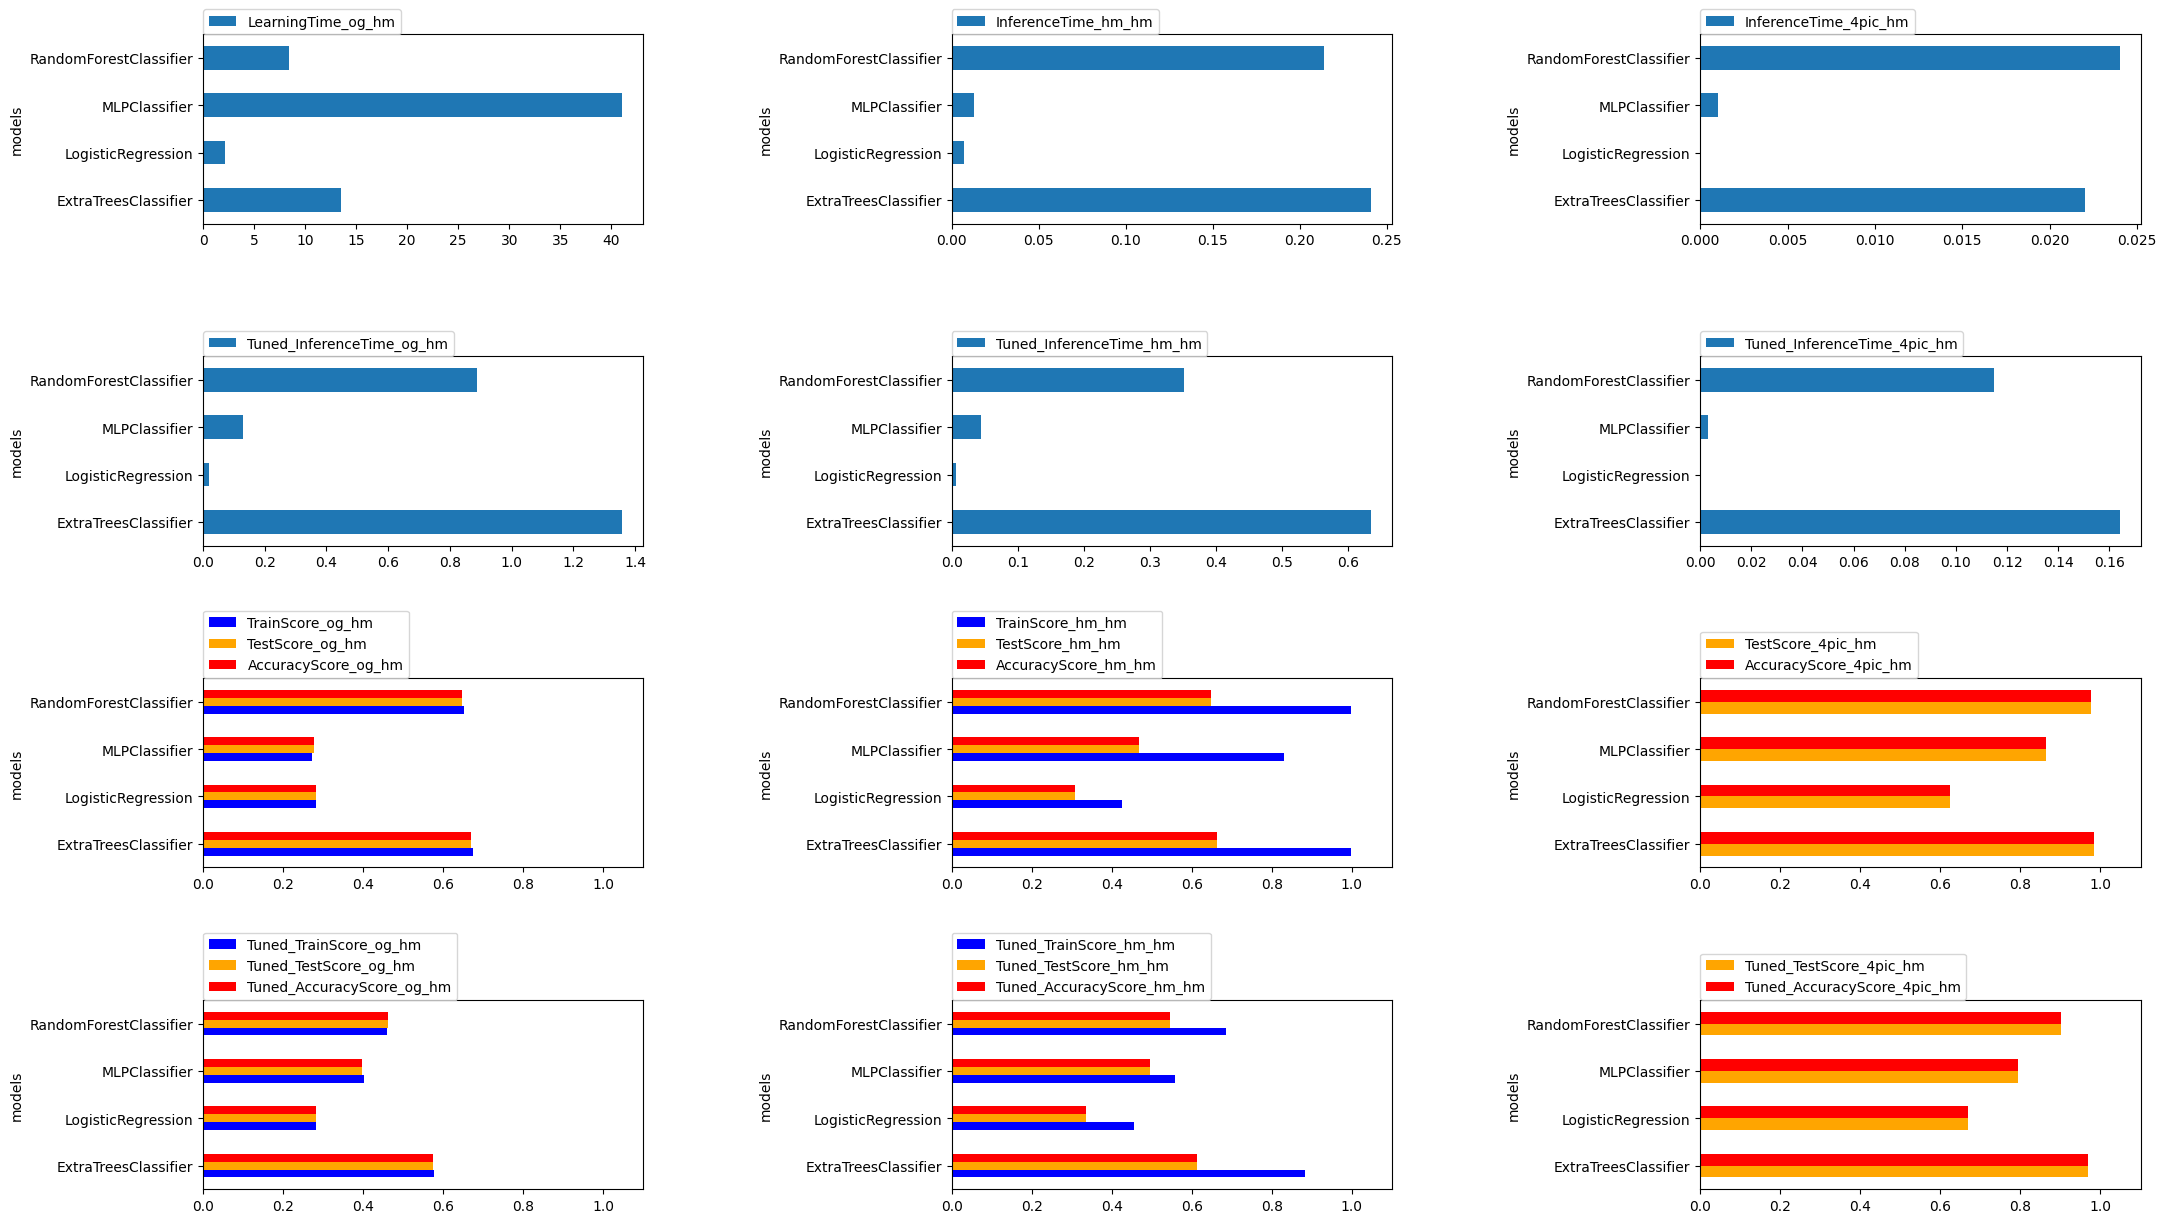

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
og_hm = {'models': list(InferenceTime_og_hm.keys()), 
      'LearningTime_og_hm':list(LearningTime_og_hm.values()),
      'InferenceTime_og_hm':list(InferenceTime_og_hm.values()),
      'TrainScore_og_hm':list(TrainScore_og_hm.values()),
      'TestScore_og_hm':list(TestScore_og_hm.values()),
      'AccuracyScore_og_hm':list(AccuracyScore_og_hm.values()),}

hm_hm = {'models': list(InferenceTime_hm_hm.keys()), 
         'InferenceTime_hm_hm':list(InferenceTime_hm_hm.values()),
         'TrainScore_hm_hm':list(TrainScore_hm_hm.values()),
         'TestScore_hm_hm':list(TestScore_hm_hm.values()),
         'AccuracyScore_hm_hm':list(AccuracyScore_hm_hm.values())}

pic_hm = {'models': list(InferenceTime_4pic_hm.keys()), 
          'InferenceTime_4pic_hm':list(InferenceTime_4pic_hm.values()),
          'TestScore_4pic_hm':list(TestScore_4pic_hm.values()),
          'AccuracyScore_4pic_hm':list(AccuracyScore_4pic_hm.values())}

Tuned_og_hm = {'models': list(Tuned_InferenceTime_og_hm.keys()), 
            'Tuned_InferenceTime_og_hm':list(Tuned_InferenceTime_og_hm.values()),
            'Tuned_TrainScore_og_hm':list(Tuned_TrainScore_og_hm.values()),
            'Tuned_TestScore_og_hm':list(Tuned_TestScore_og_hm.values()),
            'Tuned_AccuracyScore_og_hm':list(Tuned_AccuracyScore_og_hm.values()),}

Tuned_hm_hm = {'models': list(Tuned_InferenceTime_hm_hm.keys()), 
               'Tuned_InferenceTime_hm_hm':list(Tuned_InferenceTime_hm_hm.values()),
               'Tuned_TrainScore_hm_hm':list(Tuned_TrainScore_hm_hm.values()),
               'Tuned_TestScore_hm_hm':list(Tuned_TestScore_hm_hm.values()),
               'Tuned_AccuracyScore_hm_hm':list(Tuned_AccuracyScore_hm_hm.values())}

Tuned_pic_hm = {'models': list(Tuned_InferenceTime_4pic_hm.keys()), 
                'Tuned_InferenceTime_4pic_hm':list(Tuned_InferenceTime_4pic_hm.values()),
                'Tuned_TestScore_4pic_hm':list(Tuned_TestScore_4pic_hm.values()),
                'Tuned_AccuracyScore_4pic_hm':list(Tuned_AccuracyScore_4pic_hm.values())}

og_hm = pd.DataFrame(og_hm)
hm_hm = pd.DataFrame(hm_hm)
pic_hm = pd.DataFrame(pic_hm)

Tuned_og_hm = pd.DataFrame(Tuned_og_hm)
Tuned_hm_hm = pd.DataFrame(Tuned_hm_hm)
Tuned_pic_hm = pd.DataFrame(Tuned_pic_hm)

fig, ax = plt.subplots(4, 3, figsize = (25, 15))

og_hm.plot(kind='barh', x='models', y=list(og_hm.keys())[1], ax=ax[0,0])
hm_hm.plot(kind='barh', x='models', y=list(hm_hm.keys())[1], ax=ax[0,1])
pic_hm.plot(kind='barh', x='models', y=list(pic_hm.keys())[1], ax=ax[0,2])

Tuned_og_hm.plot(kind='barh', x='models', y=list(Tuned_og_hm.keys())[1], ax=ax[1,0])
Tuned_hm_hm.plot(kind='barh', x='models', y=list(Tuned_hm_hm.keys())[1], ax=ax[1,1])
Tuned_pic_hm.plot(kind='barh', x='models', y=list(Tuned_pic_hm.keys())[1], ax=ax[1,2])

og_hm.plot(kind='barh', x='models', y=list(og_hm.keys())[3:], ax=ax[2,0], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
hm_hm.plot(kind='barh', x='models', y=list(hm_hm.keys())[2:], ax=ax[2,1], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
pic_hm.plot(kind='barh', x='models', y=list(pic_hm.keys())[2:], ax=ax[2,2], xlim = (0,1.1), color = ['orange', 'red'])

Tuned_og_hm.plot(kind='barh', x='models', y=list(Tuned_og_hm.keys())[2:], ax=ax[3,0], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
Tuned_hm_hm.plot(kind='barh', x='models', y=list(Tuned_hm_hm.keys())[2:], ax=ax[3,1], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
Tuned_pic_hm.plot(kind='barh', x='models', y=list(Tuned_pic_hm.keys())[2:], ax=ax[3,2], xlim = (0,1.1), color = ['orange', 'red'])

ax[0,0].legend(loc=(0,1))
ax[0,1].legend(loc=(0,1))
ax[0,2].legend(loc=(0,1))
ax[1,0].legend(loc=(0,1))
ax[1,1].legend(loc=(0,1))
ax[1,2].legend(loc=(0,1))
ax[2,0].legend(loc=(0,1))
ax[2,1].legend(loc=(0,1))
ax[2,2].legend(loc=(0,1))
ax[3,0].legend(loc=(0,1))
ax[3,1].legend(loc=(0,1))
ax[3,2].legend(loc=(0,1))
plt.subplots_adjust(wspace=0.7, hspace=0.7)

In [22]:
og_hm

,models,LearningTime_og_hm,InferenceTime_og_hm,TrainScore_og_hm,TestScore_og_hm,AccuracyScore_og_hm
0,ExtraTreesClassifier,13.544022,0.479994,0.674876,0.670514,0.670514
1,LogisticRegression,2.144979,0.018000,0.281581,0.282514,0.282514
2,MLPClassifier,41.088998,0.035999,0.271581,0.278400,0.278400
3,RandomForestClassifier,8.418018,0.463982,0.650686,0.645771,0.645771


In [23]:
Tuned_og_hm

,models,Tuned_InferenceTime_og_hm,Tuned_TrainScore_og_hm,Tuned_TestScore_og_hm,Tuned_AccuracyScore_og_hm
0,ExtraTreesClassifier,1.358998,0.576476,0.575029,0.575029
1,LogisticRegression,0.017982,0.281200,0.282114,0.282114
2,MLPClassifier,0.131000,0.402724,0.397943,0.397943
3,RandomForestClassifier,0.888000,0.458914,0.460914,0.460914


In [24]:
hm_hm

,models,InferenceTime_hm_hm,TrainScore_hm_hm,TestScore_hm_hm,AccuracyScore_hm_hm
0,ExtraTreesClassifier,0.241000,0.997954,0.663473,0.663473
1,LogisticRegression,0.007001,0.425449,0.308383,0.308383
2,MLPClassifier,0.012999,0.830589,0.468413,0.468413
3,RandomForestClassifier,0.214025,0.997954,0.649102,0.649102


In [25]:
Tuned_hm_hm

,models,Tuned_InferenceTime_hm_hm,Tuned_TrainScore_hm_hm,Tuned_TestScore_hm_hm,Tuned_AccuracyScore_hm_hm
0,ExtraTreesClassifier,0.634000,0.883683,0.612575,0.612575
1,LogisticRegression,0.007003,0.454491,0.336078,0.336078
2,MLPClassifier,0.045001,0.558782,0.495659,0.495659
3,RandomForestClassifier,0.351998,0.685080,0.544910,0.544910


In [26]:
pic_hm

,models,InferenceTime_4pic_hm,TestScore_4pic_hm,AccuracyScore_4pic_hm
0,ExtraTreesClassifier,0.022000,0.9850,0.9850
1,LogisticRegression,0.000000,0.6250,0.6250
2,MLPClassifier,0.000998,0.8650,0.8650
3,RandomForestClassifier,0.024001,0.9775,0.9775


In [27]:
Tuned_pic_hm

,models,Tuned_InferenceTime_4pic_hm,Tuned_TestScore_4pic_hm,Tuned_AccuracyScore_4pic_hm
0,ExtraTreesClassifier,0.164001,0.9700,0.9700
1,LogisticRegression,0.000000,0.6700,0.6700
2,MLPClassifier,0.003002,0.7950,0.7950
3,RandomForestClassifier,0.115000,0.9025,0.9025


In [28]:
# 출력해야하는 지표
# 예측: prediction
# 시간: learning time, inference time
# 점수: score, accuracy
# 학습 커브: Epoch 및 learning curve
np.set_printoptions(threshold=5)

LearningTime_og_cb = {}
InferenceTime_og_cb = {}
TrainScore_og_cb = {}
TestScore_og_cb = {}
AccuracyScore_og_cb = {}
Prediction_og_cb = {}
LearningCurve_og_cb = []

InferenceTime_hm_cb = {}
TrainScore_hm_cb = {}
TestScore_hm_cb = {}
AccuracyScore_hm_cb = {}
Prediction_hm_cb = {}
LearningCurve_hm_cb = []

InferenceTime_4pic_cb = {}
TestScore_4pic_cb = {}
AccuracyScore_4pic_cb = {}
Prediction_4pic_cb = {}
LearningCurve_4pic_cb = []

InferenceTime_cb_cb = {}
TestScore_cb_cb = {}
AccuracyScore_cb_cb = {}
Prediction_cb_cb = {}
LearningCurve_cb_cb = []

In [29]:
# Combine 데이터셋에 대한 학습 진행
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

print("Combine '데이터셋 학습' / '4Pic 테스트' 진행\n")
print("위 셀의 코드 실행 확인용 소요시간 출력")
clf_cb = []
for clf_cb in classifiers_cb:
    clf_cb_time = time.time()
    start_learn = time.time()
    clf_cb.fit(X_train_cb, y_train_cb)
    end_learn = time.time()
    
    start_inference = time.time()
    y_pred_og_cb = clf_cb.predict(X_test_og)
    end_inference = time.time()
    LearningTime_og_cb[clf_cb.__class__.__name__] = (end_learn - start_learn)
    InferenceTime_og_cb[clf_cb.__class__.__name__] = (end_inference - start_inference)
    TrainScore_og_cb[clf_cb.__class__.__name__] = (clf_cb.score(X_train_og, y_train_og))
    TestScore_og_cb[clf_cb.__class__.__name__] = (clf_cb.score(X_test_og, y_test_og))
    AccuracyScore_og_cb[clf_cb.__class__.__name__] = (accuracy_score(y_test_og, y_pred_og_cb))
    Prediction_og_cb[clf_cb.__class__.__name__] = (y_pred_og_cb)
                            
    start_inference = time.time()
    y_pred_hm_cb = clf_cb.predict(X_test_hm)
    end_inference = time.time()
    
    InferenceTime_hm_cb[clf_cb.__class__.__name__] = (end_inference - start_inference)
    TrainScore_hm_cb[clf_cb.__class__.__name__] = (clf_cb.score(X_train_hm, y_train_hm))
    TestScore_hm_cb[clf_cb.__class__.__name__] = (clf_cb.score(X_test_hm, y_test_hm))
    AccuracyScore_hm_cb[clf_cb.__class__.__name__] = (accuracy_score(y_test_hm, y_pred_hm_cb))
    Prediction_hm_cb[clf_cb.__class__.__name__] = (y_pred_hm_cb)

                            
    start_inference = time.time()
    y_pred_4pic_cb = clf_cb.predict(X_4pic)
    end_inference = time.time()
    
    InferenceTime_4pic_cb[clf_cb.__class__.__name__] = (end_inference - start_inference)
    TestScore_4pic_cb[clf_cb.__class__.__name__] = (clf_cb.score(X_4pic, y_4pic))
    AccuracyScore_4pic_cb[clf_cb.__class__.__name__] = (accuracy_score(y_4pic, y_pred_4pic_cb))
    Prediction_4pic_cb[clf_cb.__class__.__name__] = (y_pred_4pic_cb)

    start_inference = time.time()
    y_pred_cb_cb = clf_cb.predict(X_cb)
    end_inference = time.time()
    
    InferenceTime_cb_cb[clf_cb.__class__.__name__] = (end_inference - start_inference)
    TestScore_cb_cb[clf_cb.__class__.__name__] = (clf_cb.score(X_cb, y_cb))
    AccuracyScore_cb_cb[clf_cb.__class__.__name__] = (accuracy_score(y_cb, y_pred_cb_cb))
    Prediction_cb_cb[clf_cb.__class__.__name__] = (y_pred_cb_cb)
    
    print(clf_cb.__class__.__name__, "완료", time.time()-clf_cb_time, "초")

Combine '데이터셋 학습' / '4Pic 테스트' 진행

위 셀의 코드 실행 확인용 소요시간 출력
ExtraTreesClassifier 완료 54.792738914489746 초
LogisticRegression 완료 8.332980632781982 초
MLPClassifier 완료 137.72300100326538 초
RandomForestClassifier 완료 37.916834354400635 초


In [30]:
best_param_cb = {}

Tuned_InferenceTime_og_cb = {}
Tuned_TrainScore_og_cb = {}
Tuned_TestScore_og_cb = {}
Tuned_AccuracyScore_og_cb = {}
Tuned_Prediction_og_cb = {}
Tuned_LearningCurve_og_cb = []

Tuned_InferenceTime_hm_cb = {}
Tuned_TrainScore_hm_cb = {}
Tuned_TestScore_hm_cb = {}
Tuned_AccuracyScore_hm_cb = {}
Tuned_Prediction_hm_cb = {}
Tuned_LearningCurve_hm_cb = []

Tuned_InferenceTime_4pic_cb = {}
Tuned_TestScore_4pic_cb = {}
Tuned_AccuracyScore_4pic_cb = {}
Tuned_Prediction_4pic_cb = {}
Tuned_LearningCurve_4pic_cb = []

Tuned_InferenceTime_cb_cb = {}
Tuned_TestScore_cb_cb = {}
Tuned_AccuracyScore_cb_cb = {}
Tuned_Prediction_cb_cb = {}
Tuned_LearningCurve_cb_cb = []


In [31]:
# Combine 데이터셋에 대한 파라미터 튜닝 진행 + learning curve에서 파라미터 별 변화 그래프 확인
with warnings.catch_warnings(): warnings.filterwarnings('ignore', category=ConvergenceWarning)
print("Combine '파라미터 튜닝' / '테스트' 진행\n")
print("위 셀의 코드 실행 확인용 소요시간 출력")
x = 0
HRS_CV_cb = []
for clf_cb in classifiers_cb:
    clf_cb_time = time.time()
    HRS_CV_cb = HalvingRandomSearchCV(clf_cb, param_distributions = params[x], cv = 3, n_jobs = -1)
    HRS_CV_cb.fit(X_train_cb, y_train_cb)
    best_param_cb[clf_cb.__class__.__name__] = HRS_CV_cb.best_params_
    
    start_inference = time.time()
    y_pred_og_cb = HRS_CV_cb.best_estimator_.predict(X_test_og)
    end_inference = time.time()
    
    Tuned_InferenceTime_og_cb[clf_cb.__class__.__name__] = end_inference - start_inference
    Tuned_TrainScore_og_cb[clf_cb.__class__.__name__] = HRS_CV_cb.best_estimator_.score(X_train_og, y_train_og)
    Tuned_TestScore_og_cb[clf_cb.__class__.__name__] = HRS_CV_cb.best_estimator_.score(X_test_og, y_test_og)
    Tuned_AccuracyScore_og_cb[clf_cb.__class__.__name__] = accuracy_score(y_test_og, y_pred_og_cb)
    Tuned_Prediction_og_cb[clf_cb.__class__.__name__] = y_pred_og_cb
    
    start_inference = time.time()
    y_pred_hm_cb = HRS_CV_cb.best_estimator_.predict(X_test_hm)
    end_inference = time.time()
    
    Tuned_InferenceTime_hm_cb[clf_cb.__class__.__name__] = end_inference - start_inference
    Tuned_TrainScore_hm_cb[clf_cb.__class__.__name__] = HRS_CV_cb.best_estimator_.score(X_train_hm, y_train_hm)
    Tuned_TestScore_hm_cb[clf_cb.__class__.__name__] = HRS_CV_cb.best_estimator_.score(X_test_hm, y_test_hm)
    Tuned_AccuracyScore_hm_cb[clf_cb.__class__.__name__] = accuracy_score(y_test_hm, y_pred_hm_cb)
    Tuned_Prediction_hm_cb[clf_cb.__class__.__name__] = y_pred_hm_cb
    
    start_inference = time.time()
    y_4pic_cb = HRS_CV_cb.best_estimator_.predict(X_4pic)
    end_inference = time.time()
    
    Tuned_InferenceTime_4pic_cb[clf_cb.__class__.__name__] = end_inference - start_inference
    Tuned_TestScore_4pic_cb[clf_cb.__class__.__name__] = HRS_CV_cb.best_estimator_.score(X_4pic, y_4pic)
    Tuned_AccuracyScore_4pic_cb[clf_cb.__class__.__name__] = accuracy_score(y_4pic, y_4pic_cb)
    Tuned_Prediction_4pic_cb[clf_cb.__class__.__name__] = y_4pic_cb

    start_inference = time.time()
    y_cb_cb = HRS_CV_cb.best_estimator_.predict(X_cb)
    end_inference = time.time()
    
    Tuned_InferenceTime_cb_cb[clf_cb.__class__.__name__] = end_inference - start_inference
    Tuned_TestScore_cb_cb[clf_cb.__class__.__name__] = HRS_CV_cb.best_estimator_.score(X_cb, y_cb)
    Tuned_AccuracyScore_cb_cb[clf_cb.__class__.__name__] = accuracy_score(y_cb, y_cb_cb)
    Tuned_Prediction_cb_cb[clf_cb.__class__.__name__] = y_cb_cb
    
    print(clf_cb.__class__.__name__, "완료", time.time()-clf_cb_time, "초")
    x+=1

Combine '파라미터 튜닝' / '테스트' 진행

위 셀의 코드 실행 확인용 소요시간 출력
ExtraTreesClassifier 완료 1208.6159987449646 초
LogisticRegression 완료 829.4415898323059 초
MLPClassifier 완료 2405.650218486786 초
RandomForestClassifier 완료 1009.7867002487183 초


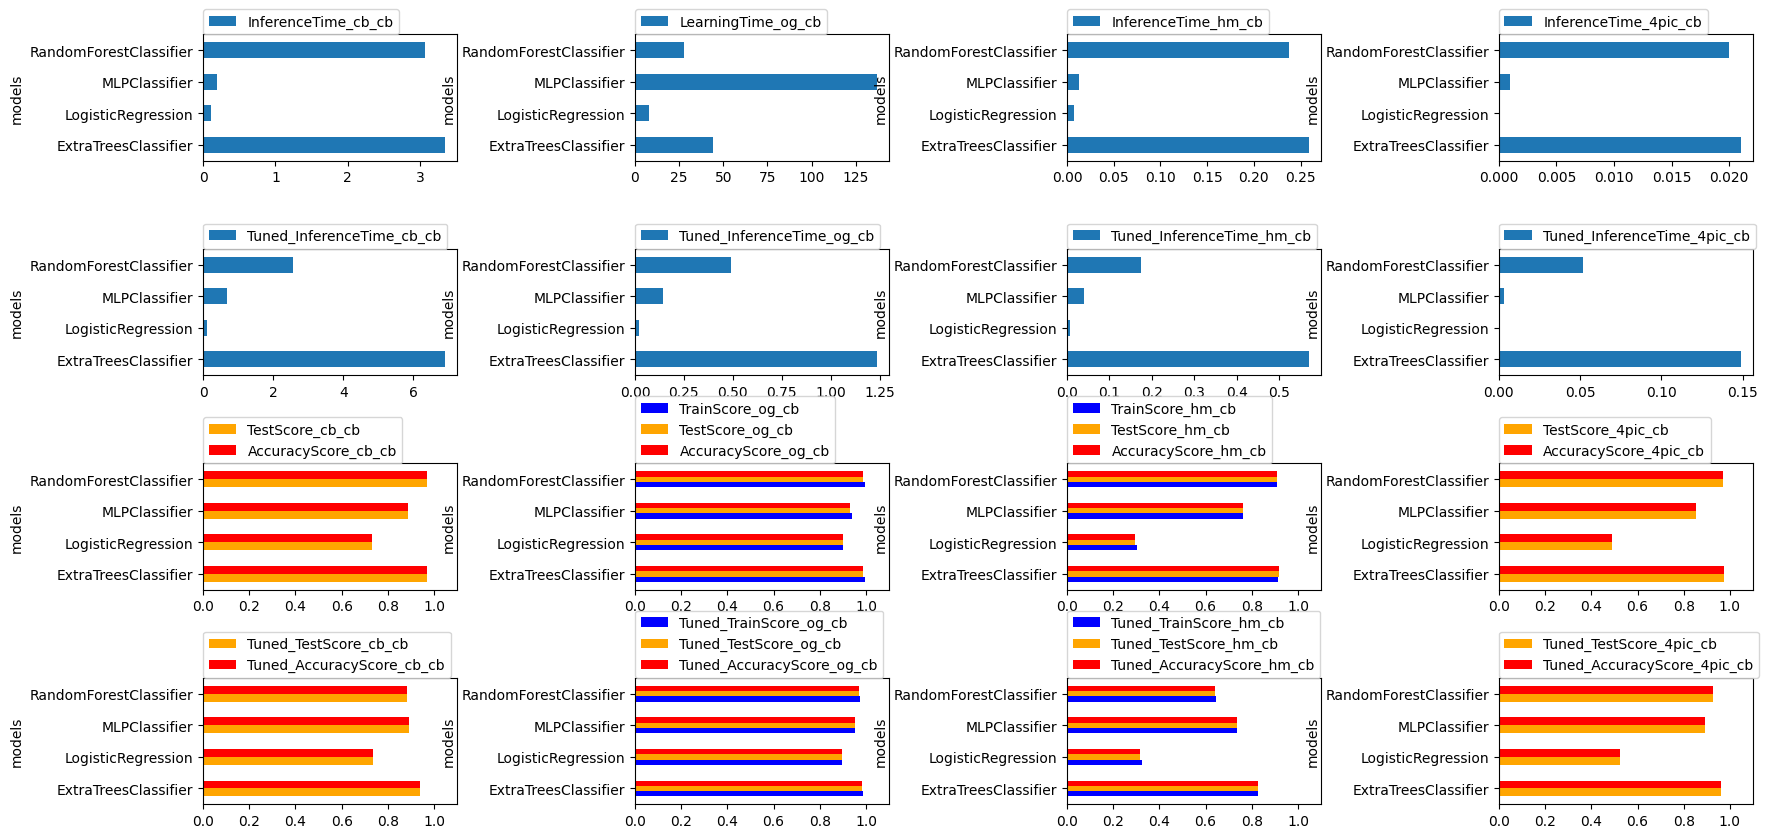

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
og_cb = {'models': list(InferenceTime_og_cb.keys()), 
      'LearningTime_og_cb':list(LearningTime_og_cb.values()),
      'InferenceTime_og_cb':list(InferenceTime_og_cb.values()),
      'TrainScore_og_cb':list(TrainScore_og_cb.values()),
      'TestScore_og_cb':list(TestScore_og_cb.values()),
      'AccuracyScore_og_cb':list(AccuracyScore_og_cb.values()),}

hm_cb = {'models': list(InferenceTime_hm_cb.keys()), 
         'InferenceTime_hm_cb':list(InferenceTime_hm_cb.values()),
         'TrainScore_hm_cb':list(TrainScore_hm_cb.values()),
         'TestScore_hm_cb':list(TestScore_hm_cb.values()),
         'AccuracyScore_hm_cb':list(AccuracyScore_hm_cb.values())}

pic_cb = {'models': list(InferenceTime_4pic_cb.keys()), 
          'InferenceTime_4pic_cb':list(InferenceTime_4pic_cb.values()),
          'TestScore_4pic_cb':list(TestScore_4pic_cb.values()),
          'AccuracyScore_4pic_cb':list(AccuracyScore_4pic_cb.values())}

cb_cb = {'models': list(InferenceTime_cb_cb.keys()), 
          'InferenceTime_cb_cb':list(InferenceTime_cb_cb.values()),
          'TestScore_cb_cb':list(TestScore_cb_cb.values()),
          'AccuracyScore_cb_cb':list(AccuracyScore_cb_cb.values())}

Tuned_og_cb = {'models': list(Tuned_InferenceTime_og_cb.keys()), 
            'Tuned_InferenceTime_og_cb':list(Tuned_InferenceTime_og_cb.values()),
            'Tuned_TrainScore_og_cb':list(Tuned_TrainScore_og_cb.values()),
            'Tuned_TestScore_og_cb':list(Tuned_TestScore_og_cb.values()),
            'Tuned_AccuracyScore_og_cb':list(Tuned_AccuracyScore_og_cb.values()),}

Tuned_hm_cb = {'models': list(Tuned_InferenceTime_hm_cb.keys()), 
               'Tuned_InferenceTime_hm_cb':list(Tuned_InferenceTime_hm_cb.values()),
               'Tuned_TrainScore_hm_cb':list(Tuned_TrainScore_hm_cb.values()),
               'Tuned_TestScore_hm_cb':list(Tuned_TestScore_hm_cb.values()),
               'Tuned_AccuracyScore_hm_cb':list(Tuned_AccuracyScore_hm_cb.values())}

Tuned_pic_cb = {'models': list(Tuned_InferenceTime_4pic_cb.keys()), 
                'Tuned_InferenceTime_4pic_cb':list(Tuned_InferenceTime_4pic_cb.values()),
                'Tuned_TestScore_4pic_cb':list(Tuned_TestScore_4pic_cb.values()),
                'Tuned_AccuracyScore_4pic_cb':list(Tuned_AccuracyScore_4pic_cb.values())}

Tuned_cb_cb = {'models': list(Tuned_InferenceTime_cb_cb.keys()), 
               'Tuned_InferenceTime_cb_cb':list(Tuned_InferenceTime_cb_cb.values()),               
               'Tuned_TestScore_cb_cb':list(Tuned_TestScore_cb_cb.values()),
               'Tuned_AccuracyScore_cb_cb':list(Tuned_AccuracyScore_cb_cb.values())}

og_cb = pd.DataFrame(og_cb)
hm_cb = pd.DataFrame(hm_cb)
pic_cb = pd.DataFrame(pic_cb)
cb_cb = pd.DataFrame(cb_cb)

Tuned_og_cb = pd.DataFrame(Tuned_og_cb)
Tuned_hm_cb = pd.DataFrame(Tuned_hm_cb)
Tuned_pic_cb = pd.DataFrame(Tuned_pic_cb)
Tuned_cb_cb = pd.DataFrame(Tuned_cb_cb)

fig, ax = plt.subplots(4,4, figsize = (20, 10))

cb_cb.plot(kind='barh', x='models', y=list(cb_cb.keys())[1], ax=ax[0,0])
og_cb.plot(kind='barh', x='models', y=list(og_cb.keys())[1], ax=ax[0,1])
hm_cb.plot(kind='barh', x='models', y=list(hm_cb.keys())[1], ax=ax[0,2])
pic_cb.plot(kind='barh', x='models', y=list(pic_cb.keys())[1], ax=ax[0,3])

Tuned_cb_cb.plot(kind='barh', x='models', y=list(Tuned_cb_cb.keys())[1], ax=ax[1,0])
Tuned_og_cb.plot(kind='barh', x='models', y=list(Tuned_og_cb.keys())[1], ax=ax[1,1])
Tuned_hm_cb.plot(kind='barh', x='models', y=list(Tuned_hm_cb.keys())[1], ax=ax[1,2])
Tuned_pic_cb.plot(kind='barh', x='models', y=list(Tuned_pic_cb.keys())[1], ax=ax[1,3])

cb_cb.plot(kind='barh', x='models', y=list(cb_cb.keys())[2:], ax=ax[2,0], xlim = (0,1.1), color = ['orange', 'red'])
og_cb.plot(kind='barh', x='models', y=list(og_cb.keys())[3:], ax=ax[2,1], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
hm_cb.plot(kind='barh', x='models', y=list(hm_cb.keys())[2:], ax=ax[2,2], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
pic_cb.plot(kind='barh', x='models', y=list(pic_cb.keys())[2:], ax=ax[2,3], xlim = (0,1.1), color = ['orange', 'red'])

Tuned_cb_cb.plot(kind='barh', x='models', y=list(Tuned_cb_cb.keys())[2:], ax=ax[3,0], xlim = (0,1.1), color = ['orange', 'red'])
Tuned_og_cb.plot(kind='barh', x='models', y=list(Tuned_og_cb.keys())[2:], ax=ax[3,1], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
Tuned_hm_cb.plot(kind='barh', x='models', y=list(Tuned_hm_cb.keys())[2:], ax=ax[3,2], xlim = (0,1.1), color = ['blue', 'orange', 'red'])
Tuned_pic_cb.plot(kind='barh', x='models', y=list(Tuned_pic_cb.keys())[2:], ax=ax[3,3], xlim = (0,1.1), color = ['orange', 'red'])




ax[0,0].legend(loc=(0,1))
ax[0,1].legend(loc=(0,1))
ax[0,2].legend(loc=(0,1))
ax[0,3].legend(loc=(0,1))
ax[1,0].legend(loc=(0,1))
ax[1,1].legend(loc=(0,1))
ax[1,2].legend(loc=(0,1))
ax[1,3].legend(loc=(0,1))
ax[2,0].legend(loc=(0,1))
ax[2,1].legend(loc=(0,1))
ax[2,2].legend(loc=(0,1))
ax[2,3].legend(loc=(0,1))
ax[3,0].legend(loc=(0,1))
ax[3,1].legend(loc=(0,1))
ax[3,2].legend(loc=(0,1))
ax[3,3].legend(loc=(0,1))

plt.subplots_adjust(wspace=0.7, hspace=0.7)

In [33]:
og_cb

,models,LearningTime_og_cb,InferenceTime_og_cb,TrainScore_og_cb,TestScore_og_cb,AccuracyScore_og_cb
0,ExtraTreesClassifier,43.979228,0.633000,0.994800,0.987771,0.987771
1,LogisticRegression,7.984981,0.019001,0.898667,0.898971,0.898971
2,MLPClassifier,137.043001,0.036999,0.937733,0.929029,0.929029
3,RandomForestClassifier,27.745832,0.593001,0.994095,0.987143,0.987143


In [34]:
Tuned_og_cb

,models,Tuned_InferenceTime_og_cb,Tuned_TrainScore_og_cb,Tuned_TestScore_og_cb,Tuned_AccuracyScore_og_cb
0,ExtraTreesClassifier,1.237000,0.986933,0.981257,0.981257
1,LogisticRegression,0.019004,0.894438,0.894286,0.894286
2,MLPClassifier,0.141999,0.951829,0.951314,0.951314
3,RandomForestClassifier,0.492999,0.975829,0.970229,0.970229


In [35]:
hm_cb

,models,InferenceTime_hm_cb,TrainScore_hm_cb,TestScore_hm_cb,AccuracyScore_hm_cb
0,ExtraTreesClassifier,0.258993,0.915220,0.915868,0.915868
1,LogisticRegression,0.007003,0.301896,0.295060,0.295060
2,MLPClassifier,0.013000,0.760978,0.760180,0.760180
3,RandomForestClassifier,0.237984,0.908832,0.908832,0.908832


In [36]:
Tuned_hm_cb

,models,Tuned_InferenceTime_hm_cb,Tuned_TrainScore_hm_cb,Tuned_TestScore_hm_cb,Tuned_AccuracyScore_hm_cb
0,ExtraTreesClassifier,0.570001,0.825349,0.824850,0.824850
1,LogisticRegression,0.008001,0.325699,0.318263,0.318263
2,MLPClassifier,0.041001,0.735279,0.735329,0.735329
3,RandomForestClassifier,0.174001,0.644212,0.640419,0.640419


In [37]:
pic_cb

,models,InferenceTime_4pic_cb,TestScore_4pic_cb,AccuracyScore_4pic_cb
0,ExtraTreesClassifier,0.021019,0.9725,0.9725
1,LogisticRegression,0.000000,0.4875,0.4875
2,MLPClassifier,0.001000,0.8550,0.8550
3,RandomForestClassifier,0.020017,0.9700,0.9700


In [38]:
Tuned_pic_cb

,models,Tuned_InferenceTime_4pic_cb,Tuned_TestScore_4pic_cb,Tuned_AccuracyScore_4pic_cb
0,ExtraTreesClassifier,0.148999,0.960,0.960
1,LogisticRegression,0.000000,0.525,0.525
2,MLPClassifier,0.002999,0.890,0.890
3,RandomForestClassifier,0.051998,0.925,0.925


In [39]:
cb_cb

,models,InferenceTime_cb_cb,TestScore_cb_cb,AccuracyScore_cb_cb
0,ExtraTreesClassifier,3.341510,0.971588,0.971588
1,LogisticRegression,0.103998,0.733385,0.733385
2,MLPClassifier,0.193003,0.887273,0.887273
3,RandomForestClassifier,3.063999,0.969282,0.969282


In [40]:
Tuned_cb_cb

,models,Tuned_InferenceTime_cb_cb,Tuned_TestScore_cb_cb,Tuned_AccuracyScore_cb_cb
0,ExtraTreesClassifier,6.902999,0.941232,0.941232
1,LogisticRegression,0.100999,0.736776,0.736776
2,MLPClassifier,0.677000,0.891915,0.891915
3,RandomForestClassifier,2.567998,0.882940,0.882940


In [ ]:
from sklearn.metrics import accuracy_score

In [153]:

def learning_curve2(clf, epoch, X_train , X_test , y_train , y_test, best):
    train_by = f'{X_train=}'.split('=')[0]

    if( best == True):   
        best_param = best_param_cb[clf.__class__.__name__]    
        if(clf.__class__.__name__ == 'log_cb'):
            best_param['max_iter'] = 1
        best_param['warm_start'] = True
        clf.set_params(**best_param)            
        print(best_param)
        best_param    

    
    if(best != True):
        clf.set_params(random_state = 42, warm_start = True)

    ac_train = [] 
    ac_test = []
    fit_time = []
    score_train = []
    scoer_test = [] 

    inference_time_train = [] 
    inference_time_test = []
    for epoch in range(1,epoch):
    
        clf.fit(X_train, y_train)      

        y_train_predict = clf.predict(X_train)    
        
        y_test_predict = clf.predict(X_test)
      
        ac_train.append(accuracy_score(y_train, y_train_predict))
        ac_test.append(accuracy_score(y_test, y_test_predict))      

    
    # 정확도 차트  
    epoch_range = np.arange(1, epoch + 1)
    plt.figure(figsize = (10, 4))
    plt.subplots_adjust(hspace=5)

    plt.subplot(1,1,1)
    plt.plot(epoch_range, ac_train)
    plt.plot(epoch_range, ac_test)    
    plt.title(f'{clf.__class__.__name__} Accuracy_{train_by}')
    plt.xlabel('Epoch')
    plt.ylabel("Accuracy")
    plt.legend( ['Train', 'Test']  )
    plt.figure(figsize = (5, 5))
    plt.subplots_adjust(hspace=5)    
    
    plt.show()
    

In [5]:

def learning_curve_no_set_params(clf, epoch, X_train , X_test , y_train , y_test):
    train_by = f'{X_train=}'.split('=')[0]

    
    ac_train = [] 
    ac_test = []
    fit_time = []
    score = []


    inference_time_train = [] 
    inference_time_test = []
    for epoch in range(1,epoch):
    
        clf.fit(X_train, y_train)      

        y_train_predict = clf.predict(X_train)    
        
        y_test_predict = clf.predict(X_test)
        best_score = clf.score(X_team,y_team)

        
        ac_test.append(accuracy_score(y_test, y_test_predict))  
        score.append(best_score)    

    
    # 정확도 차트  
    epoch_range = np.arange(1, epoch + 1)
    plt.figure(figsize = (10, 4))
    plt.subplots_adjust(hspace=5)

    plt.subplot(1,1,1)
    plt.plot(epoch_range, ac_test)    
    plt.plot(epoch_range, score)
    plt.title(f'{clf.__class__.__name__} Accuracy & score_{train_by}')
    plt.xlabel('Epoch')
    plt.ylabel("Accuracy & score")
    plt.legend( ['Train', 'Test']  )
    plt.figure(figsize = (5, 5))
    plt.subplots_adjust(hspace=5)    
    
    plt.show()
    

{'random_state': 42, 'n_jobs': 6, 'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini', 'warm_start': True}


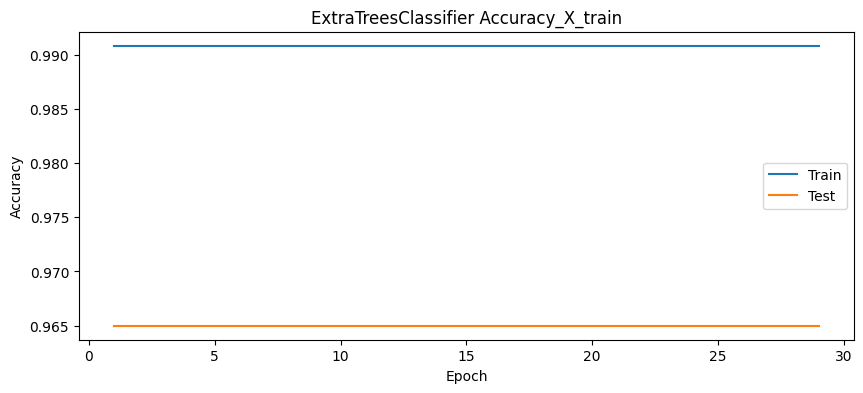

<Figure size 500x500 with 0 Axes>

{'solver': 'adam', 'random_state': 42, 'max_iter': 500, 'learning_rate_init': 0.001, 'hidden_layer_sizes': 145, 'alpha': 0.0001, 'activation': 'logistic', 'warm_start': True}


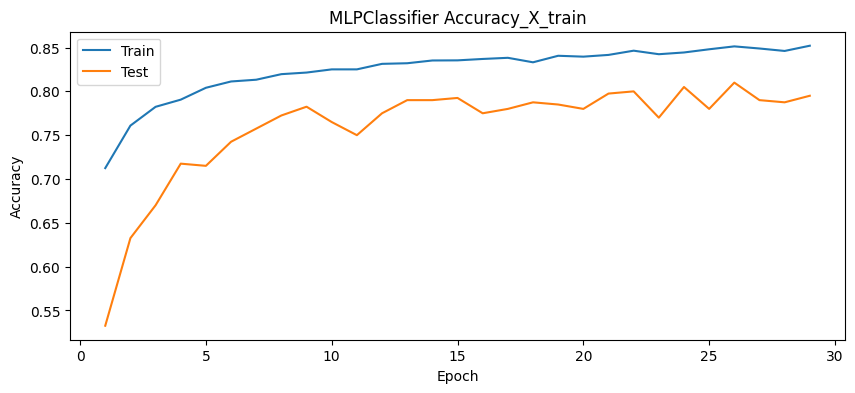

<Figure size 500x500 with 0 Axes>

In [147]:
for clf in et_cb, mlp_cb: 
    learning_curve2(clf, 30, X_train_cb, X_4pic, y_train_cb, y_4pic, True)  

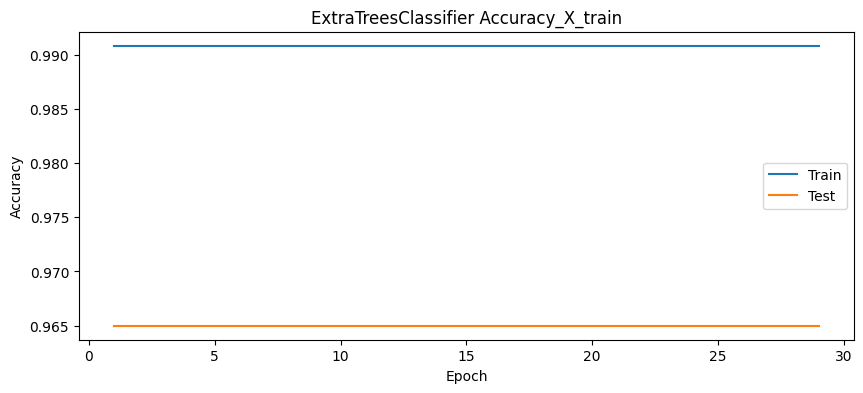

<Figure size 500x500 with 0 Axes>

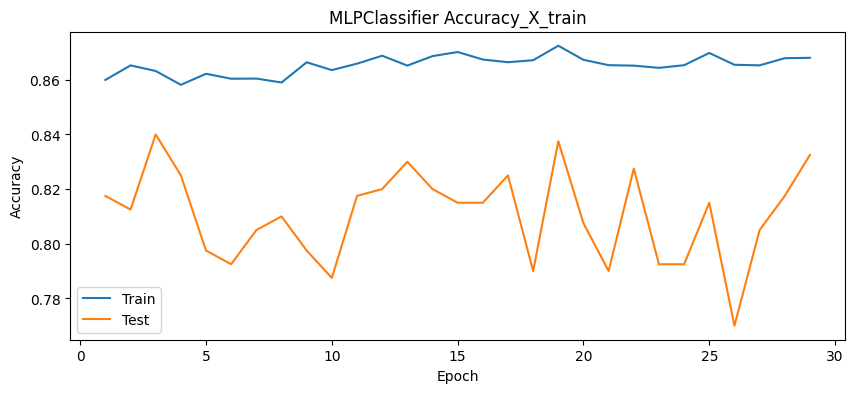

<Figure size 500x500 with 0 Axes>

In [154]:
for clf in et_cb, mlp_cb: 
    learning_curve2(clf, 30, X_train_cb, X_4pic, y_train_cb, y_4pic, False)  

In [ ]:
for clf in log_cb, rf_cb: 
    learning_curve2(clf, 30, X_train_cb, X_4pic, y_train_cb, y_4pic, True)  

In [ ]:
for clf in log_cb, rf_cb: 
    learning_curve2(clf, 30, X_train_cb, X_4pic, y_train_cb, y_4pic, False)  

In [80]:
#classifiers_cb = [et_cb, log_cb, mlp_cb, rf_cb]
best_param_cb['ExtraTreesClassifier']


{'random_state': 42,
 'n_jobs': 6,
 'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'gini'}

In [149]:
def best_model(clf, X_train , best):
       

    best_param = best_param_cb[clf.__class__.__name__]
    best_param['warm_start'] = True
    print(best_param)
    clf.set_params(**best_param)            
    best_param    

    
    return clf

In [159]:
best_et_clf = ExtraTreesClassifier()


In [160]:

best_model(best_et_clf,X_train_cb,True)


{'random_state': 42, 'n_jobs': 6, 'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini', 'warm_start': True}


ExtraTreesClassifier(max_depth=30, min_samples_leaf=5, min_samples_split=10,
                     n_estimators=800, n_jobs=6, random_state=42,
                     warm_start=True)

In [6]:
best_et_clf.fit(X_train_cb,y_train_cb)


best_et_score = best_et_clf.score(X_4pic,y_4pic)

print('best_et_score : %f',best_et_score )


best_et_score : %f 0.96


In [10]:
for epoch in range(1,50):
    best_et_clf.fit(X_train_cb,y_train_cb)

In [11]:
best_et_score = best_et_clf.score(X_team,y_team)

print('best_et_score : %f',best_et_score )

best_et_score : %f 0.419


In [ ]:
#best_et_clf=ExtraTreesClassifier(max_depth=30, min_samples_leaf=5, min_samples_split=10,n_estimators=800, n_jobs=6, random_state=42, warm_start=True)

In [11]:
best_mlp = MLPClassifier(solver= 'adam', random_state= 42, max_iter= 1, learning_rate_init= 0.001, hidden_layer_sizes= 145, alpha= 0.0001, activation= 'logistic', warm_start= True)

In [14]:
best_mlp.fit(X_train_cb,y_train_cb)


best_mlp_score = best_mlp.score(X_team,y_team)

print('best_mlp_score : %f',best_mlp_score )

best_mlp_score : %f 0.4503333333333333


In [ ]:
best_mlp = MLPClassifier(solver= 'adam', random_state= 42, max_iter= 1, learning_rate_init= 0.001, hidden_layer_sizes= (200,100), alpha= 0.0001, activation= 'logistic', warm_start= True)

In [16]:
best_mlp.fit(X_train_cb,y_train_cb)


best_mlp_score = best_mlp.score(X_team,y_team)

print('best_mlp_score : %f',best_mlp_score )

best_mlp_score : %f 0.5426666666666666


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

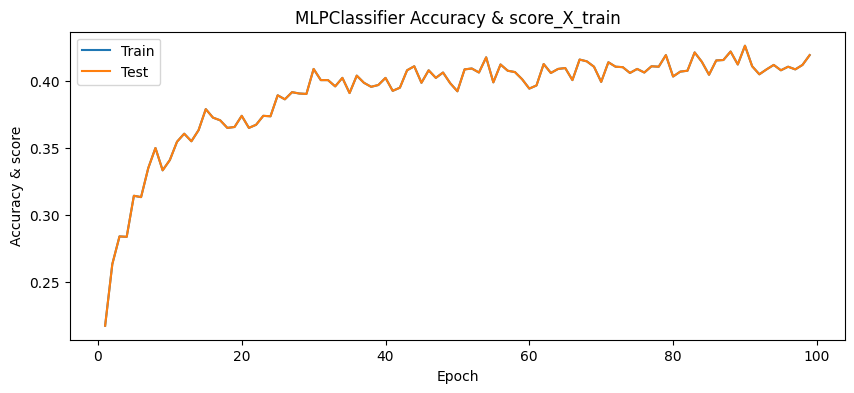

<Figure size 500x500 with 0 Axes>

In [12]:

learning_curve_no_set_params(best_mlp,100, X_train_cb, X_team, y_train_cb, y_team)

In [13]:

learning_curve_no_set_params(best_mlp,300, X_train_cb, X_team, y_train_cb, y_team)

In [ ]:
best_mlp.set_params(max_iter = 1)
learning_curve_no_set_params(best_mlp,100, X_train_cb, X_team, y_train_cb, y_team)

In [ ]:
best_mlp.fit(X_train_cb,y_train_cb)


best_mlp_score = best_mlp.score(X_team,y_team)

print('best_mlp_score : %f',best_mlp_score )

In [ ]:
X_cb = np.concatenate((X_cb, X_team), axis=0)
y_cb = np.concatenate((y_cb, y_team), axis=0)
X_cb = X_cb.reshape(len(X_cb),784)
X_train_cb, X_test_cb , y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, random_state=42)

In [ ]:


best_mlp.fit(X_train_cb,y_train_cb)


best_mlp_score = best_mlp.score(X_team,y_team)

print('best_mlpscore : %f',best_mlp_score )